# 0. Imports and Useful Functions from Other Notebooks

In [1]:
# !pip install git+https://github.com/NMBU-Data-Science/RENT.git

In [2]:
# !pip install --upgrade pip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('female_test.pkl')
dft = pd.read_pickle('female_train.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, ElasticNetCV
from datetime import datetime

In [2]:
# from RENT import RENT, stability
import time
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [3]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

In [4]:
# df_train = {}
# for idx in range(len(df)):
#     name = dft.iloc[idx].modality
# #     data = dft.iloc[idx].dataframe.output_age_decon.to_list()
#     data = dft.iloc[idx].dataframe.mean_output_age.to_list()
#     df_train[name] = data
    
# df_train = pd.DataFrame.from_dict(df_train)
# df_train['target_age'] = dft.iloc[0].dataframe.target_age.to_list()

In [5]:
from sklearn.model_selection import train_test_split

df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [6]:
df_train

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
2820,66.709417,67.442993,61.093726,62.254519,69.164342,63.855006,67.249040,58.140988,62.120589,64.160736,...,62.182788,61.906055,63.804283,61.755967,58.793064,62.017001,62.214266,65.457215,64.070314,66.449886
1708,60.944236,61.842161,58.154415,63.287874,59.937619,60.383603,64.117655,57.543353,54.386728,55.125870,...,59.943876,59.250686,62.674294,59.842834,60.130049,60.041532,60.133045,58.552697,60.884393,56.750799
3530,69.986284,70.044437,67.995620,68.787147,66.860631,63.243362,65.436874,67.694233,64.469723,67.990499,...,69.095557,68.243078,70.294473,71.528098,68.952060,68.205580,68.265059,67.692567,71.046120,74.181393
3480,50.189046,49.536327,55.061271,52.386892,51.970549,55.862569,54.179867,54.311277,60.954406,58.720743,...,52.460709,51.984690,52.651951,51.896004,51.796198,53.048449,51.241098,53.523593,52.749642,48.054909
670,71.524370,74.981445,69.319275,72.855853,68.487738,74.630128,70.888287,67.358183,62.182683,68.813820,...,69.198738,68.378360,69.722930,69.319782,69.967300,67.481915,68.142391,68.747928,68.246657,71.225457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,72.453860,72.777170,71.681043,71.683783,68.714974,69.766270,65.685925,68.641963,70.857667,65.476047,...,72.687613,70.522855,69.902572,70.420770,72.571650,73.341687,71.503297,68.441695,70.658153,68.973630
2763,53.351702,52.271532,55.079981,52.161547,53.909411,59.786398,53.030368,53.165982,57.423242,53.322554,...,54.309854,54.178987,56.800108,56.448681,54.016900,55.505735,58.626230,55.986900,56.154284,54.153767
905,69.209973,69.500987,68.698557,66.651488,68.785348,63.463698,66.667837,69.449155,71.894450,69.530817,...,63.842171,67.179692,66.388185,68.495769,66.448707,68.125218,69.551362,71.481080,67.318527,69.441940
3980,52.488741,52.919326,49.097110,55.224999,54.686887,56.643762,55.647718,51.043516,51.264160,49.018145,...,52.269901,53.618629,52.570537,50.347670,49.235783,51.978335,49.282260,49.503878,51.560833,55.862215


# Define RENT ensemble for regression

In [9]:
train_data = df_train.loc[:, df_train.columns != 'target_age']
train_labels = df_train['target_age']

test_data = df_test.loc[:, df_test.columns != 'target_age']
test_labels = df_test['target_age']

In [10]:
feat_names = df_train.columns[:-1].to_list()
feat_names

['T1_nonlinear',
 'T1_linear',
 'jacobian',
 'vbm',
 'T2_nonlinear',
 'T2_lesions',
 'swi',
 'rsfmri_0',
 'rsfmri_1',
 'rsfmri_2',
 'rsfmri_3',
 'rsfmri_4',
 'rsfmri_5',
 'rsfmri_6',
 'rsfmri_7',
 'rsfmri_8',
 'rsfmri_9',
 'rsfmri_10',
 'rsfmri_11',
 'rsfmri_12',
 'rsfmri_13',
 'rsfmri_14',
 'rsfmri_15',
 'rsfmri_16',
 'rsfmri_17',
 'rsfmri_18',
 'rsfmri_19',
 'rsfmri_20',
 'rsfmri_21',
 'rsfmri_22',
 'rsfmri_23',
 'rsfmri_24',
 'tfmri_1',
 'tfmri_2',
 'tfmri_5',
 'tfmri_c_1',
 'tfmri_c_2',
 'tfmri_c_5',
 'tracts',
 'tbss_FA_s',
 'tbss_ICVF_s',
 'tbss_ISOVF_s',
 'tbss_L1_s',
 'tbss_L2_s',
 'tbss_L3_s',
 'tbss_MD_s',
 'tbss_MO_s',
 'tbss_OD_s',
 'tbss_FA',
 'tbss_ICVF',
 'tbss_ISOVF',
 'tbss_L1',
 'tbss_L2',
 'tbss_L3',
 'tbss_MD',
 'tbss_MO',
 'tbss_OD']

In [11]:
train_data

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
2820,66.709417,67.442993,61.093726,62.254519,69.164342,63.855006,67.249040,58.140988,62.120589,64.160736,...,62.374906,62.182788,61.906055,63.804283,61.755967,58.793064,62.017001,62.214266,65.457215,64.070314
1708,60.944236,61.842161,58.154415,63.287874,59.937619,60.383603,64.117655,57.543353,54.386728,55.125870,...,61.829482,59.943876,59.250686,62.674294,59.842834,60.130049,60.041532,60.133045,58.552697,60.884393
3530,69.986284,70.044437,67.995620,68.787147,66.860631,63.243362,65.436874,67.694233,64.469723,67.990499,...,71.638821,69.095557,68.243078,70.294473,71.528098,68.952060,68.205580,68.265059,67.692567,71.046120
3480,50.189046,49.536327,55.061271,52.386892,51.970549,55.862569,54.179867,54.311277,60.954406,58.720743,...,53.015953,52.460709,51.984690,52.651951,51.896004,51.796198,53.048449,51.241098,53.523593,52.749642
670,71.524370,74.981445,69.319275,72.855853,68.487738,74.630128,70.888287,67.358183,62.182683,68.813820,...,72.819603,69.198738,68.378360,69.722930,69.319782,69.967300,67.481915,68.142391,68.747928,68.246657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,72.453860,72.777170,71.681043,71.683783,68.714974,69.766270,65.685925,68.641963,70.857667,65.476047,...,68.233270,72.687613,70.522855,69.902572,70.420770,72.571650,73.341687,71.503297,68.441695,70.658153
2763,53.351702,52.271532,55.079981,52.161547,53.909411,59.786398,53.030368,53.165982,57.423242,53.322554,...,56.451362,54.309854,54.178987,56.800108,56.448681,54.016900,55.505735,58.626230,55.986900,56.154284
905,69.209973,69.500987,68.698557,66.651488,68.785348,63.463698,66.667837,69.449155,71.894450,69.530817,...,65.182157,63.842171,67.179692,66.388185,68.495769,66.448707,68.125218,69.551362,71.481080,67.318527
3980,52.488741,52.919326,49.097110,55.224999,54.686887,56.643762,55.647718,51.043516,51.264160,49.018145,...,52.104970,52.269901,53.618629,52.570537,50.347670,49.235783,51.978335,49.282260,49.503878,51.560833


In [12]:
train_labels.head()

2820    66.449886
1708    56.750799
3530    74.181393
3480    48.054909
670     71.225457
Name: target_age, dtype: float64

In [13]:
train_data.loc[[8]]

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
8,63.407553,61.214864,60.971878,65.329056,64.146725,59.593823,65.773108,58.636584,58.032532,60.899171,...,59.992842,57.91302,62.238066,64.092919,63.515263,62.07229,62.812563,63.726452,59.338239,60.521898


In [14]:
new_idxs = np.arange(0,train_data.shape[0],1)
train_data.index = list(new_idxs)
train_data

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
0,66.709417,67.442993,61.093726,62.254519,69.164342,63.855006,67.249040,58.140988,62.120589,64.160736,...,62.374906,62.182788,61.906055,63.804283,61.755967,58.793064,62.017001,62.214266,65.457215,64.070314
1,60.944236,61.842161,58.154415,63.287874,59.937619,60.383603,64.117655,57.543353,54.386728,55.125870,...,61.829482,59.943876,59.250686,62.674294,59.842834,60.130049,60.041532,60.133045,58.552697,60.884393
2,69.986284,70.044437,67.995620,68.787147,66.860631,63.243362,65.436874,67.694233,64.469723,67.990499,...,71.638821,69.095557,68.243078,70.294473,71.528098,68.952060,68.205580,68.265059,67.692567,71.046120
3,50.189046,49.536327,55.061271,52.386892,51.970549,55.862569,54.179867,54.311277,60.954406,58.720743,...,53.015953,52.460709,51.984690,52.651951,51.896004,51.796198,53.048449,51.241098,53.523593,52.749642
4,71.524370,74.981445,69.319275,72.855853,68.487738,74.630128,70.888287,67.358183,62.182683,68.813820,...,72.819603,69.198738,68.378360,69.722930,69.319782,69.967300,67.481915,68.142391,68.747928,68.246657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,72.453860,72.777170,71.681043,71.683783,68.714974,69.766270,65.685925,68.641963,70.857667,65.476047,...,68.233270,72.687613,70.522855,69.902572,70.420770,72.571650,73.341687,71.503297,68.441695,70.658153
2507,53.351702,52.271532,55.079981,52.161547,53.909411,59.786398,53.030368,53.165982,57.423242,53.322554,...,56.451362,54.309854,54.178987,56.800108,56.448681,54.016900,55.505735,58.626230,55.986900,56.154284
2508,69.209973,69.500987,68.698557,66.651488,68.785348,63.463698,66.667837,69.449155,71.894450,69.530817,...,65.182157,63.842171,67.179692,66.388185,68.495769,66.448707,68.125218,69.551362,71.481080,67.318527
2509,52.488741,52.919326,49.097110,55.224999,54.686887,56.643762,55.647718,51.043516,51.264160,49.018145,...,52.104970,52.269901,53.618629,52.570537,50.347670,49.235783,51.978335,49.282260,49.503878,51.560833


In [15]:
my_C_params = [0.1, 1, 10]
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns.to_list(), 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
#                                 autoEnetParSel=False,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=50,
                                random_state=0,
                                verbose=1)

data dimension: (2511, 57)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (2511,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
poly: OFF
number of models in ensemble: 50
random state: 0
verbose: 1


## A deeper insight into RENT hyperparameter selection with cross-validation

In [16]:
cv_score, cv_zeros, cv_harmonic_mean = model.get_cv_matrices()

In [17]:
cv_harmonic_mean

Harmonic Mean,0.1,1.0,10.0
0.00,0.000000,0.000000,0.000000
0.10,0.000000,0.575551,0.147277
0.25,0.262997,0.673797,0.536492
0.50,0.512744,0.445736,0.573033
0.75,NaN,0.228955,0.570924
0.90,NaN,0.545736,0.597170
1.00,NaN,0.000000,0.613660


## Train RENT ensemble and inspect results

In [18]:
model.train()

In [19]:
model.get_runtime()

0.7177982330322266

In [20]:
model.get_enet_params()

(1.0, 0.25)

## Set selection criteria cutoffs

In [50]:
selected_features = model.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

In [51]:
selected_features

array([ 0,  1,  2,  3,  4,  6, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56])

In [52]:
train_data.columns[selected_features]

Index(['T1_nonlinear', 'T1_linear', 'jacobian', 'vbm', 'T2_nonlinear', 'swi',
       'tfmri_1', 'tfmri_2', 'tfmri_5', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5',
       'tracts', 'tbss_FA_s', 'tbss_ICVF_s', 'tbss_L1_s', 'tbss_L2_s',
       'tbss_L3_s', 'tbss_MD_s', 'tbss_MO_s', 'tbss_OD_s', 'tbss_FA',
       'tbss_ICVF', 'tbss_ISOVF', 'tbss_L1', 'tbss_L2', 'tbss_L3', 'tbss_MD',
       'tbss_MO', 'tbss_OD'],
      dtype='object')

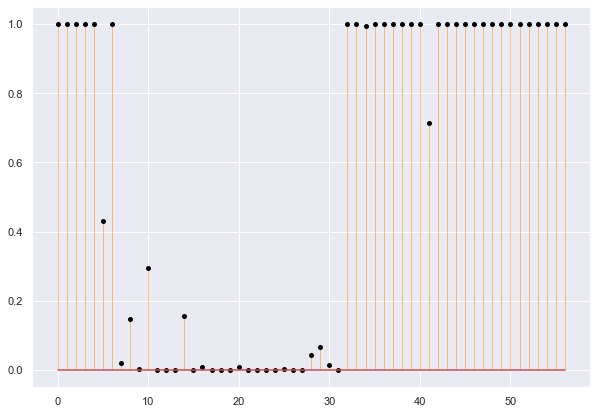

In [56]:
model.plot_selection_frequency()

In [25]:
weight_dist = model.get_weight_distributions(binary=False)
weight_dist

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_OD_s,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD
mod 1,0.600524,0.510668,0.118416,0.386491,0.605756,0.045296,0.232834,0.0,0.000000,0.0,...,0.170009,0.290335,0.319163,0.241870,0.178864,0.175791,0.184530,0.178105,0.205878,0.239136
mod 2,0.595337,0.495382,0.100737,0.400478,0.609100,0.000000,0.247824,0.0,0.000000,0.0,...,0.159287,0.275186,0.327598,0.236811,0.176949,0.177219,0.175202,0.171847,0.231847,0.226759
mod 3,0.612332,0.526740,0.098837,0.362076,0.619494,0.000000,0.234745,0.0,0.000000,0.0,...,0.190416,0.289077,0.330525,0.254563,0.177435,0.165841,0.171746,0.174501,0.225138,0.250876
mod 4,0.609106,0.515908,0.099361,0.397802,0.625013,0.000000,0.234309,0.0,0.000000,0.0,...,0.171992,0.296869,0.338043,0.253964,0.178686,0.172632,0.195488,0.186051,0.242267,0.242666
mod 5,0.581515,0.487001,0.140551,0.377364,0.598673,0.002311,0.224725,0.0,0.000000,0.0,...,0.162345,0.279368,0.305127,0.245660,0.181143,0.184788,0.189490,0.187268,0.216711,0.235251
mod 6,0.598462,0.499484,0.119976,0.380013,0.592547,0.011228,0.218003,0.0,0.000000,0.0,...,0.170474,0.281887,0.330480,0.242582,0.159901,0.173398,0.186974,0.173165,0.244434,0.251930
mod 7,0.596346,0.500058,0.105428,0.383775,0.629046,0.000000,0.253740,0.0,0.000000,0.0,...,0.158833,0.291733,0.331087,0.248306,0.157985,0.156595,0.190445,0.174331,0.234730,0.229554
mod 8,0.599189,0.506886,0.091748,0.381530,0.606984,0.000000,0.229645,0.0,0.000000,0.0,...,0.162075,0.285612,0.318961,0.228793,0.173492,0.170862,0.178194,0.181719,0.218794,0.237480
mod 9,0.597173,0.508450,0.092675,0.366685,0.612694,0.037890,0.224592,0.0,0.000000,0.0,...,0.173446,0.290828,0.336651,0.239447,0.167195,0.165615,0.186221,0.173599,0.225217,0.234252
mod 10,0.606777,0.514684,0.085400,0.386340,0.629845,0.000000,0.220747,0.0,0.000000,0.0,...,0.145424,0.311268,0.329953,0.264754,0.174213,0.165504,0.185622,0.172328,0.211770,0.227547


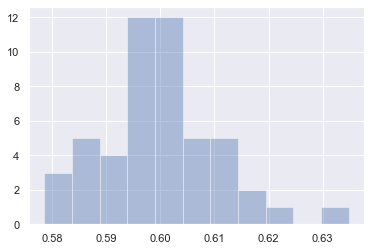

In [26]:
ax = sns.distplot(weight_dist.values[:, 0], kde=False)

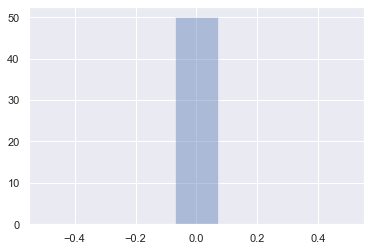

In [27]:
ax = sns.distplot(weight_dist.values[:, 23], kde=False)

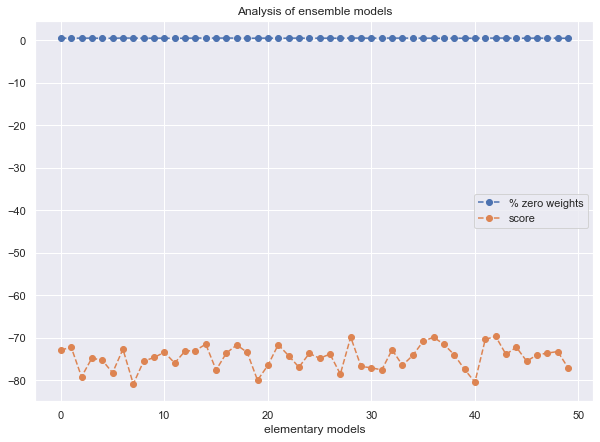

In [28]:
model.plot_elementary_models()

## Check performance using only selected features

### Linear Regression

In [29]:
# Scale the data accordingly
# sc = StandardScaler()
# train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
# test_data_1 = sc.transform(test_data.iloc[:, selected_features])
train = train_data.values[:,selected_features]
test = test_data.values[:,selected_features]

# Train model with 
prediction_model = LinearRegression().fit(train, train_labels)

# Print results
print("R2: ", r2_score(test_labels, prediction_model.predict(test)))
print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test))))

R2:  0.8821819189913235
RMSEP:  2.501761653075873


In [30]:
test_outputs = prediction_model.predict(test)
test_outputs_decon = age_deconfounding(test_outputs, test_labels)
Age_Deltas_decon = test_outputs_decon - test_labels

In [31]:
print("MAE Decon:", np.abs(Age_Deltas_decon).mean())

MAE Decon: 2.1191730545667475


### ElasticNet with CV

In [32]:
train = train_data.values[:,selected_features]
test = test_data.values[:,selected_features]

# Train model with 
prediction_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(train, train_labels)

# Print results
print("R2: ", r2_score(test_labels, prediction_model.predict(test)))
print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test))))

R2:  0.8819851529418193
RMSEP:  2.50384985717381


In [33]:
test_outputs = prediction_model.predict(test)
test_outputs_decon = age_deconfounding(test_outputs, test_labels)
Age_Deltas_decon = test_outputs_decon - test_labels

In [34]:
print("MAE Decon:", np.abs(Age_Deltas_decon).mean())


### TO DO-  ADD IN HERE A MAP TO SHOP THE WEIGHTS FOR THE SELECTED FEATURES!

MAE Decon: 2.1205565616197135


In [35]:
df_output = pd.DataFrame.from_dict({
    'modality': 'RENT',
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon
                })]
})

output_name = 'female_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon 0 2573...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon 0 2573...
0,ElasticNetFull,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster1,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster2,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster3,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster4,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster5,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster6,Unnamed: 0 age_delta_decon 0 2573...
0,Cluster7,Unnamed: 0 age_delta_decon 0 2573...


## Validation study regarding the features selected by RENT

mean VS1 0.8643069312381971
VS1: p-value for average score from random feature drawing:  4.478887658955005e-19
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 -0.8932662171390887
VS2: p-value for average score from permutation of test labels:  0.0
VS2: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.


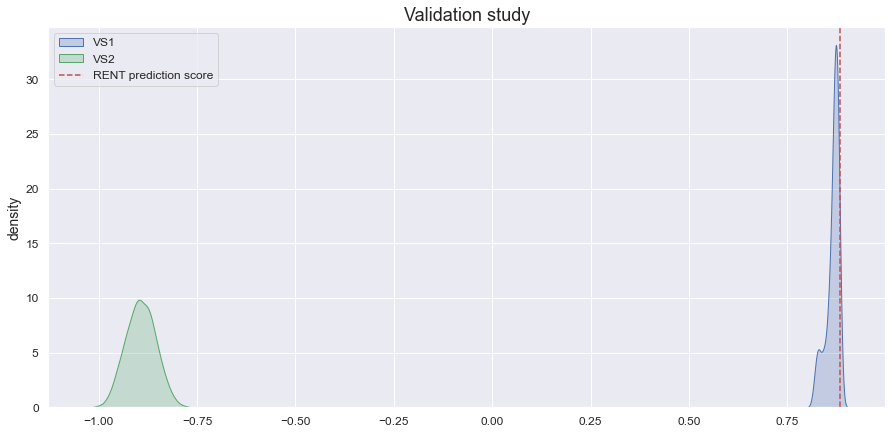

In [36]:
model.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

loo


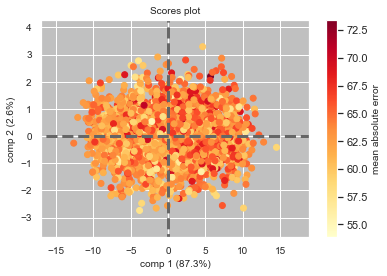

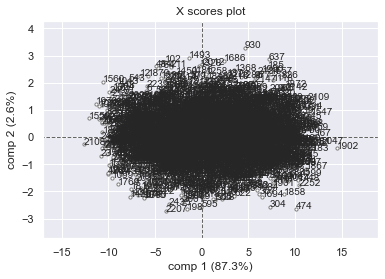

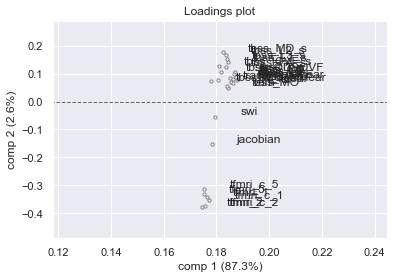

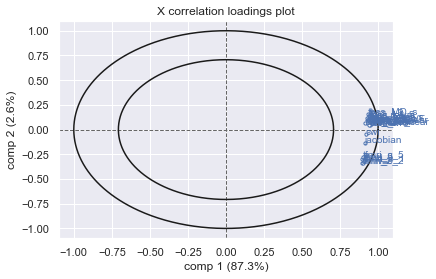

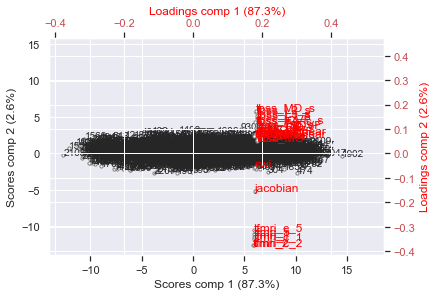

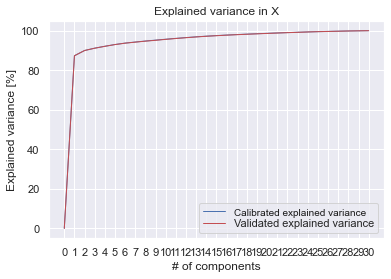

In [37]:
model.get_summary_objects()
model.plot_object_PCA(cl='continuous', problem="regression")

# Stability analysis of RENT

In [38]:
M=10 # number of runs 
alpha = 0.05 # level of significance for the confidence interval 
d = len(train_data.columns) # number of features
counts = [2, 5, 10, 50, 100, 300, 500] # values to compare (K)
C, l1 = model.get_enet_params()

# Store outputs in dictionaries
times = {}
stabilities = {}
perf = {}
num_feats = {}

start = time.time()

for count in counts:
    time_count = []
    Z_net = np.zeros((M,d), dtype=np.int8)
    performance = np.zeros(M)
    numFeatures = np.zeros(M)
    
    for i in range(M):
        model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=count,
                                random_state=None,
                                verbose=0)
        model.train()
        features = model.select_features(0.9,0.9,0.975)
        time_count.append(model.get_runtime())
        
        #prediction model
#         sc = StandardScaler()
#         train = sc.fit_transform(train_data.values[:,features])
#         test = sc.transform(test_data.values[:,features])
        train = train_data.values[:,features]
        test = test_data.values[:,features]
        ML_model =LinearRegression().fit(train, train_labels)
        performance[i] = r2_score(test_labels, ML_model.predict(test))
        Z_net[i,features] = 1
        numFeatures[i] = len(features)
    
    times[count] = time_count
    stabilities[count] = stability.confidenceIntervals(Z_net, alpha=alpha)
    perf[count] = performance
    num_feats[count] = numFeatures    

end = time.time()

print('Runtime: ', end - start)

Runtime:  683.8082222938538


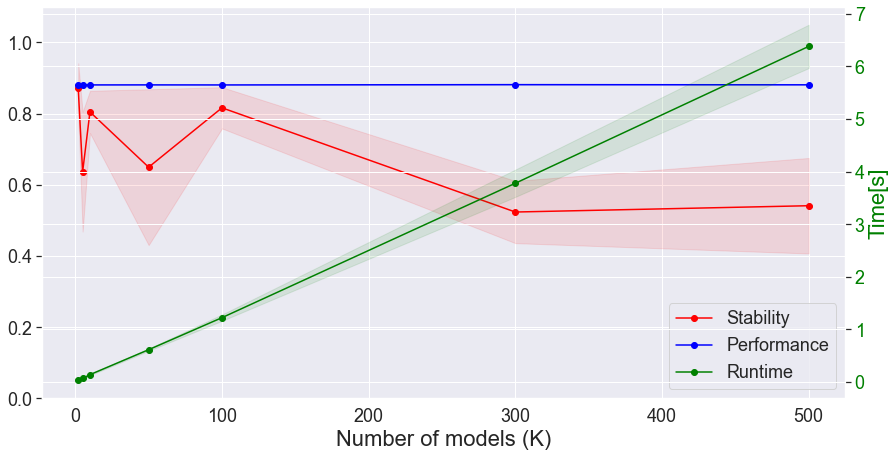

In [59]:
def stability_plot(x_levels, stabilities, accuracies, times):

    title_font_size=22
    ticks_font_size=18
    legend_font = 18
    figsize = (14.4, 7.2)
    
    stability = np.array(list({k: v['stability'] for k, v in stabilities.items()}.values()))
    stab_error = stability - np.array(list({k: v['lower'] for k, v in stabilities.items()}.values()))
    performance = np.array(list({k: np.mean(v) for k, v in accuracies.items()}.values()))
    performance_error = np.array(list({k: np.std(v) for k, v in accuracies.items()}.values()))
    runtime = np.array(list({k: np.mean(v) for k, v in times.items()}.values()))
    runtime_errors = np.array(list({k: np.std(v) for k, v in times.items()}.values())) 

    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.set_xlabel('Number of models (K)', fontsize=title_font_size)
    stab = ax1.plot(x_levels,stability, color="red", label='Stability', marker='o')
    ax1.fill_between(x_levels, (stability-stab_error), (stability+stab_error),color="red", alpha=0.1 )
    perf = ax1.plot(x_levels,performance, color="blue", label='Performance', marker='o')
    ax1.fill_between(x_levels, (performance-performance_error), (performance+performance_error),color="blue", alpha= 0.1 )
    plt.ylim(0,1.1)
    plt.yticks(fontsize=ticks_font_size)
    plt.xticks(fontsize=ticks_font_size)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Time[s]', color='green',  fontsize=title_font_size)
    tim = ax2.plot(x_levels,runtime, color="green", label='Runtime', marker='o')
    ax2.fill_between(x_levels, (runtime-runtime_errors), (runtime+runtime_errors), color="green", alpha=0.1)
    ax2.tick_params(axis='y', labelcolor="green")

    leg = stab + perf + tim
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=4, fontsize=legend_font)
    plt.xticks(fontsize=ticks_font_size)
    plt.yticks(fontsize=ticks_font_size)
    
    plt.savefig('Famele_RENT_stability_analysis.png', bbox_inches='tight', facecolor='white')


stability_plot(counts, stabilities, perf, times)

In [8]:
def ElasticNet_wrap(df_train, df_test, cross_validation_flag = False, 
                    modalities = None, number_of_modalities=None, 
                    show_plots=False, verbose=False, fix_alpha_one=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    if cross_validation_flag == True:
#         l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
#         model = ElasticNetCV(l1_ratio=l1_ratio,
# #                              n_alphas=n_alphas
#                             )
            l1_ratio = [0.01, 
                    .1, .11, .12, 0.13, 0.14, .15, .16, 0.17, 0.18, .19,
                    .2, .21, .22, 0.23, 0.24, .25, .26, 0.27, 0.28, .29,
                    0.3, 0.4, 
                    .5, .51, .52, 0.53, 0.54, .55, .56, 0.57, 0.58, .59,
                    .6, .61, .62, 0.63, 0.64, .65, .66, 0.67, 0.68, .69,
                    .7, .71, .72, 0.73, 0.74, .75, .76, 0.77, 0.78, .79,
                     0.8, .9, .91, .92, 0.93, 0.94, .95, .96, 0.97, 0.98, .99, 1.0]
            n_alphas = 1000
            model = ElasticNetCV(l1_ratio=l1_ratio,
                                 n_alphas=n_alphas
                                )
    else:
        model = ElasticNet(alpha=0.14766659013829683, l1_ratio=1.0)

    start_time = datetime.now()
        
    reg = model.fit(Xtrain.T, Ytrain)
    
    end_time = datetime.now()
    
    
    coefficients = reg.coef_
    intercept = reg.intercept_
     
    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        print('Time To Complete: {}'.format(end_time - start_time))
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon,  Yhat, Age_Deltas)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

In [9]:
modalities = ['T1_nonlinear', 'T1_linear', 'jacobian', 'vbm', 'T2_nonlinear', 'swi',
       'tfmri_1', 'tfmri_2', 'tfmri_5', 'tfmri_c_1', 'tfmri_c_2', 'tfmri_c_5',
       'tracts', 'tbss_FA_s', 'tbss_ICVF_s', 'tbss_L1_s', 'tbss_L2_s',
       'tbss_L3_s', 'tbss_MD_s', 'tbss_MO_s', 'tbss_OD_s', 'tbss_FA',
       'tbss_ICVF', 'tbss_ISOVF', 'tbss_L1', 'tbss_L2', 'tbss_L3', 'tbss_MD',
       'tbss_MO', 'tbss_OD']

In [13]:
x = ElasticNet_wrap(df_train, df_test, modalities=modalities, 
               number_of_modalities=None, show_plots=False, verbose=False,
               cross_validation_flag = True, deconfound=True)

cluster_name = 'Cluster' + str(idx)

df_output = pd.DataFrame.from_dict({
    'modality': 'RENT',
    'dataframe': [pd.DataFrame.from_dict({
                        'Unnamed: 0': subjects_testB,
                        'age_delta_decon': x[10],
                        'mean_age_delta': x[12],
                        'target_age': df_testB.target_age.values,
                        'mean_output_age': x[11]
                        })]
        })



In [65]:
output_name = 'female_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon mean_age_de...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon mean_age_de...
0,ElasticNetFull,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster1,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster2,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster3,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster4,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster5,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster6,Unnamed: 0 age_delta_decon mean_age_de...
0,Cluster7,Unnamed: 0 age_delta_decon mean_age_de...


In [43]:
x[3]

2.1206210735956588

In [44]:
x[3]

2.1206210735956588

In [45]:
abs(df_output.iloc[0].dataframe.age_delta_decon).mean()

2.1206210735956588

In [46]:
abs(df_ensambles.iloc[-1].dataframe.age_delta_decon).mean()

2.250145183564154

MAE= 1.9873208069671016
PR= 0.939154834227044
Time To Complete: 0:00:34.487886
MAE Decon= 2.1206210735956588
PR Decon= 0.9391548342270438


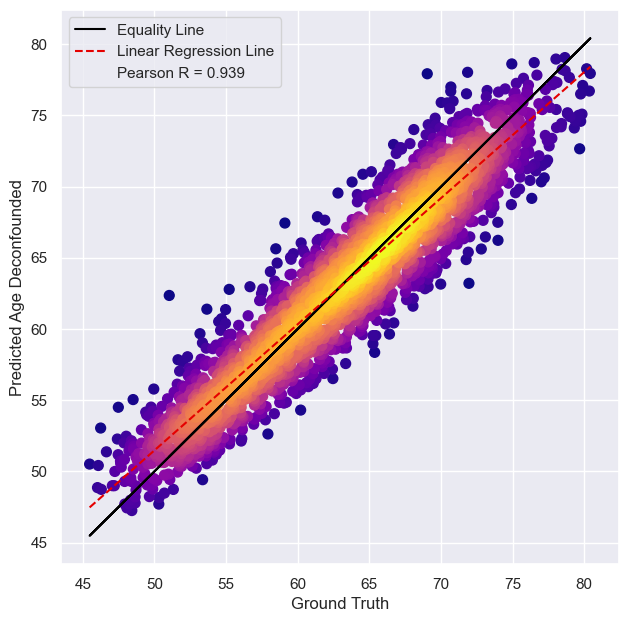

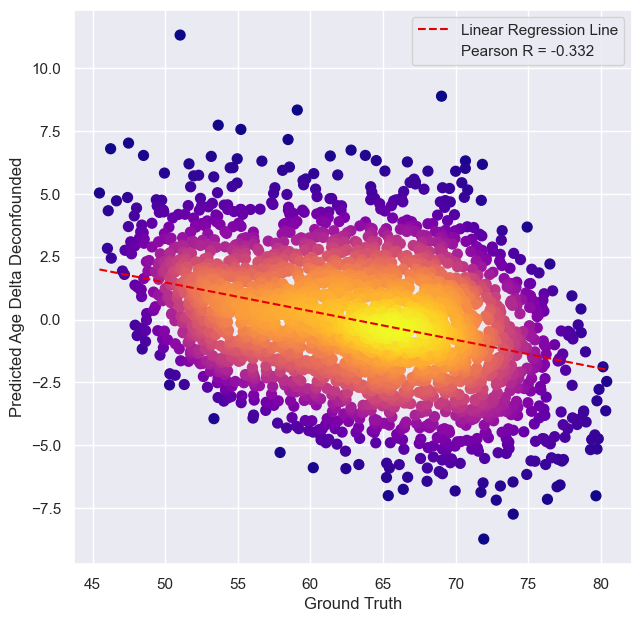

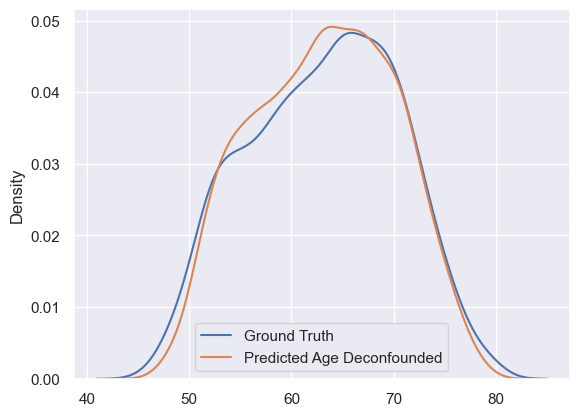

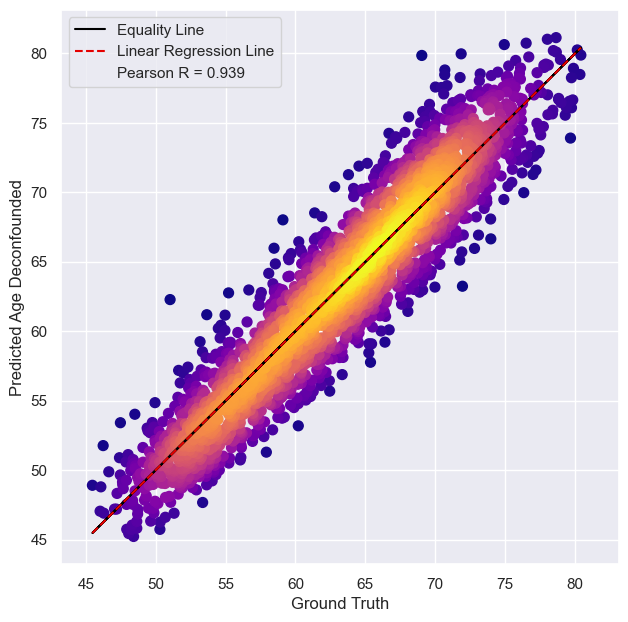

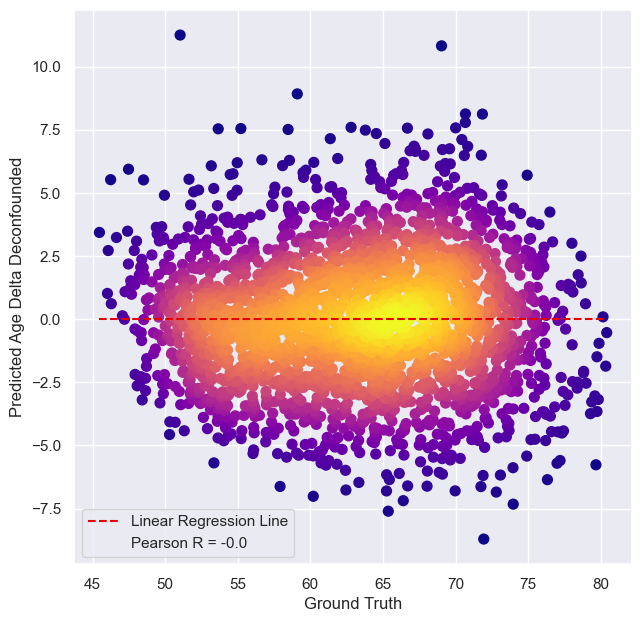

1.0779876075220223
-4.980404855205059
0.08868867902056231 0.8


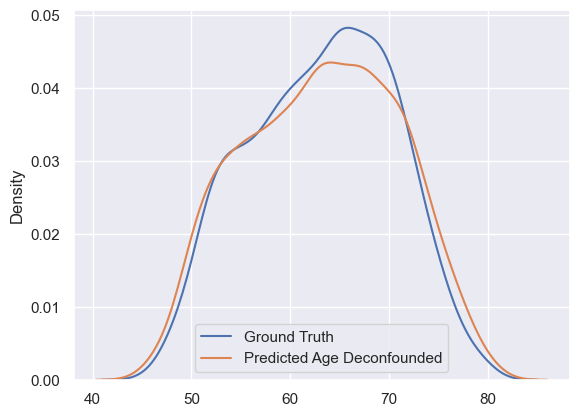

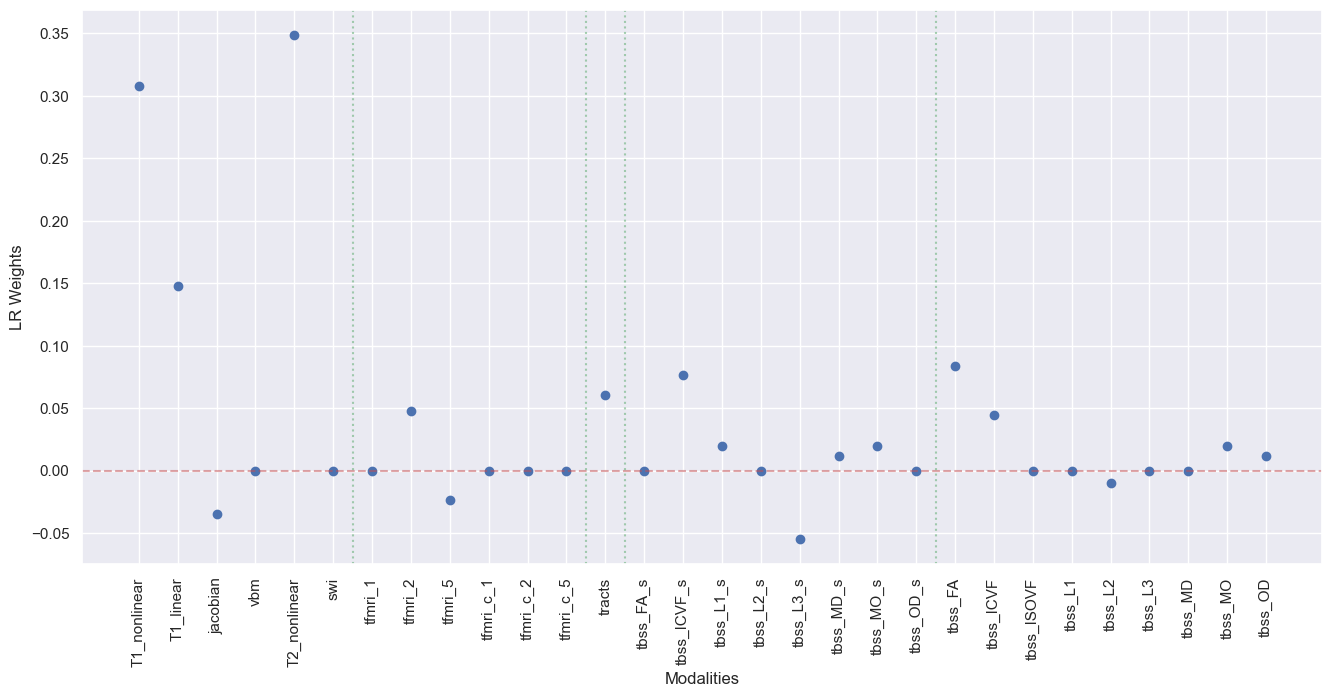

In [11]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, _, _= ElasticNet_wrap(
                    df_train, df_test, modalities = modalities, number_of_modalities=None, show_plots=True, verbose=True, 
                    cross_validation_flag = True, fix_alpha_one=False, deconfound=True)

plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), modalities, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);
plt.axvline(x=5.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=11.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5);
plt.axvline(x=20.5, color='g', linestyle='dotted', alpha=0.5);
print(coefficients.sum())
print(reg.intercept_)
print(reg.alpha_, reg.l1_ratio_)

In [10]:
output_name = 'female_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        df_ensambles.iloc[np.where(df_ensambles.modality.to_numpy()=='RENT')[0][0]].dataframe = df_output.dataframe[0]
        df_ensambles.to_pickle(output_name, protocol = 4)
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

NameError: name 'df_output' is not defined

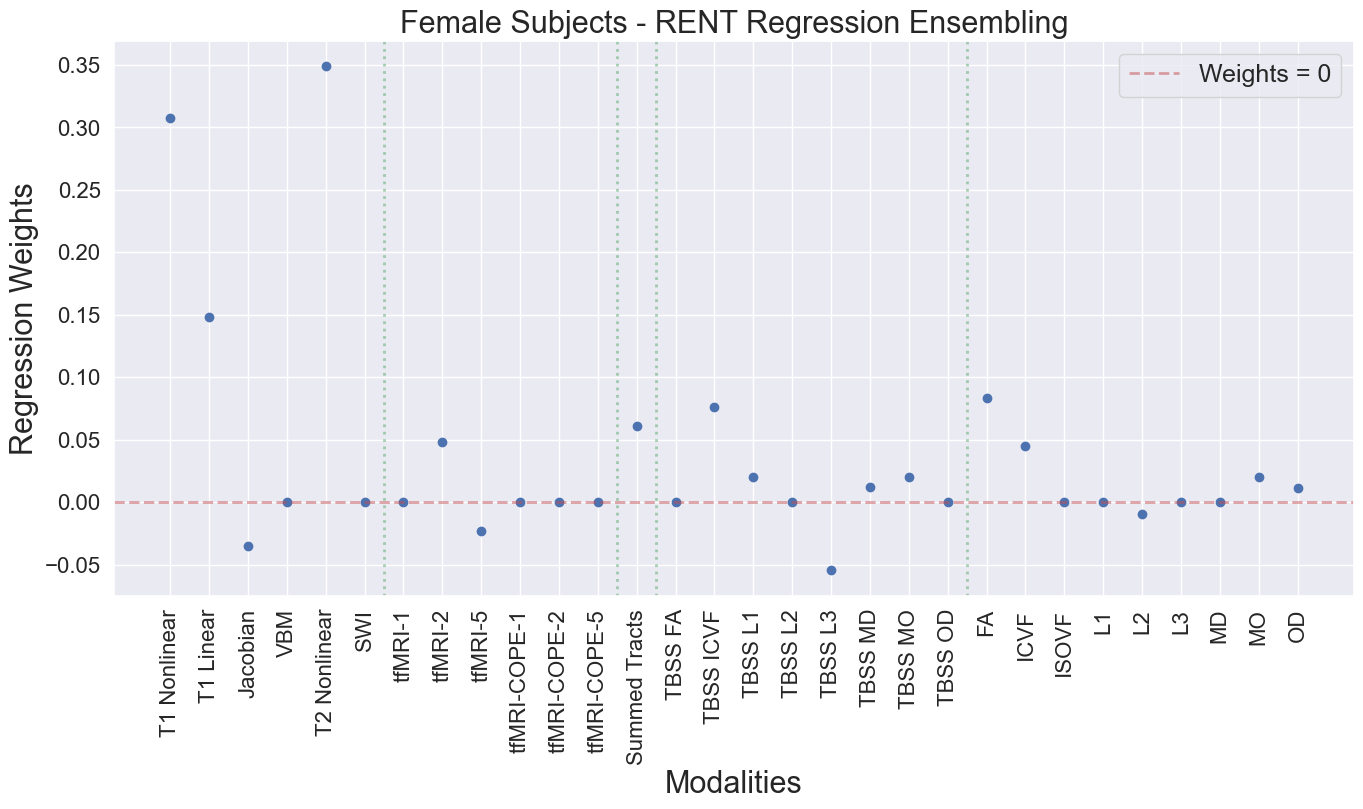

In [12]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'SWI', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0');
plt.axvline(x=5.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=11.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=12.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=20.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);


plt.legend(loc=1, fontsize=legend_font)

plt.title('Female Subjects - RENT Regression Ensembling', fontsize=title_font_size)

fig.savefig('Female_RENT_weights.png', bbox_inches='tight')


